In [1]:
# 使用したライブラリ
import math
import scipy.optimize as opt # fsolveを使用するときのライブラリ
import fslv_calc_PMV_PPD as PMV_PPD # PMV、PPDを計算するモジュール (fsolve)
import calc_PMV_PPD # PMV、PPDを計算するモジュール (反復法)
import clo_PMV_Graph as  clo_graph # 空気温度別による着衣量、PMVを示すグラフ
import ta_var_PMV as ta_graph # 気流別による空気温度とPMVを示すグラフ

# 温熱環境

温熱環境要素は以下の6つである。<br>
人体的影響によるもの：**代謝量**、**着衣量**<br>
物理的影響によるもの：**空気温度**、**放射温度**、**気流**、**湿度**

人の熱収支を式1 に示す。
$$ M - W - C_{sen} - E_{tat} = C + R + E + C_{d} + S \tag{1}$$
$S$ > 0 のとき、体温が上がり暑さを感じ、$S$ < 0 のとき、体温が下がり寒さを感じる。<br>
$M$: 代謝量 、$W$: 仕事、$C_{sen}$: 呼吸による顕熱放射、$E_{tat}$：呼吸による蒸発放熱、$C$：皮膚からの対流放熱、$R$: 皮膚からの放射放熱、$E$: 皮膚からの蒸発放熱、
$C_{d}$：皮膚からの伝導放熱、$S$：人体の熱収支バランス量 (単位は全て [W/m<sup>2</sup>] )

**代謝量**：<br>
人が運動等で仕事や熱を発生させて、燃焼していることをいう。[met] という単位で表される。<br>
椅子安静時の単位表面積あたりの放熱量で、1 [met] = 58.15 [W/m<sup>2</sup>]とする。

**着衣量**：<br>
衣服による熱抵抗すなわち、衣服の断熱性を示す。[clo] という単位で表される。1 [clo] = 0.155 [m<sup>2</sup>・K/W] とする。<br>
数値が大きいほど、衣服の断熱性が高い(厚着になる)。スーツが1 [clo] とされている。

**空気温度**：<br>
ここでは人体の周りの温度をいう。

**放射温度**：<br>
通常、周囲の表面温度は均一でないため、周囲の表面温度を平均化したものを平均放射温度 MRT (**M**ean **R**adiant **T**emperature)である(式2)。
$$ \theta_{mrt} = \sqrt[4]{\Sigma F_{i}(\theta_{si} + 273)^4} - 273 \tag{2}$$

$\theta_{mrt}$: 平均放射温度 [℃]、$\theta_{si}$: 周壁・天井・床面などの表面温度 [℃]、$F_{i}$: 周壁・天井・床面等との人体の形態係数


**気流**： <br>
空気の流れのことをいう。温度が同じでも気流が速いと汗が蒸発し人の体感温度が下がる。

**湿度**：<br>
温熱感に影響を与え高湿度のときは汗による冷却効果を阻害したりする。



### 温熱環境の指標

**作用温度 OT** (**O**perative **T**emperature)：<br>
対流、放射の影響を考慮した温度。空気温度、対流伝達率、放射熱伝達率、平均放射温度の重みより
$$ \theta_{OT} = \frac{\alpha_{c}\theta{r} + \alpha_{r}\theta_{mrt}}{\alpha_{c} + \alpha_{r}} \tag{3}$$
となる。また、式3より$\alpha_{c} + \alpha_{r}$ を整理すると空気温度と平均放射温度の平均から計算できる。<br>
$$ \theta_{OT} =  \frac{\theta_{r}+ \theta_{mrt}}{2} \tag{3´}$$
$\theta_{OT}$： 作用温度 [℃]、$\theta_{r}$： 空気温度 [℃]、$\theta_{mrt}$： 平均放射温度[℃]、$\alpha_{c}$： 人体の対流熱伝達率 [W/(m<sup>2</sup>・K)]、
$\alpha_{r}$： 人体の放射熱伝達率 [W/(m<sup>2</sup>・K)] 


### 例題

室内の空気温度が20 ℃、平均放射温度が24.3 ℃のときの作用温度 $\theta_{OT}$ は？<br>
ただし、人体の対流熱伝達率、放射熱伝導率を4.7 [W/(m<sup>2</sup>・K)]とする。<br>

式3 より
$$ \theta_{OT} = \frac{4.7 \times 20.0 + 4.7 \times 24.3}{4.7 + 4.7} = \frac{208.21}{9.40} = 22.2 [℃] $$

または式3´より
$$ \theta_{OT} = \frac{20.0 + 24.3}{2} = \frac{44.3}{2} = 22.2 [℃] $$
となる。

**有効温度 ET** (**E**ffective **T**emperature)：<br>
温度、湿度、気流を考慮した温度。<br>
相対湿度 100 %、気流 0 m/s 室A と温度、湿度、気流が決まっていない室B 間で
実験したときに室B が室Aと同等の温熱環境と体感できたときの温度を有効温度 ET [℃]という。

<div align="center"><img src="ET.png" alt="alt テキスト" title="ET" width="40%"></div>

$$ 図1-1　有効温度 \ \mathrm{ET} $$

__新有効温度 ET*__ (New **E**ffective **T**emperature)：<br>
評価方法はETと同じであるが、温度、湿度、気流、放射温度、代謝量、着衣量を考慮した温度。相対湿度が100 %を基準としていたET に対して、
ET* は相対湿度を50%を基準とした。

<div align="center"><img src="NewET.png" alt="alt テキスト" title="ET*" width="40%"></div>

$$ 図1-2　新有効温度 \ \mathrm{ET}^* $$


__標準新有効温度 SET*__ (New **S**tandard **E**ffective **T**emperature)：<br>
ET* の室A は気流、代謝量、着衣量が任意になっていたが、気流 0.1 m/s、代謝量 1.0 met、着衣量 0.6 cloとして評価する。
評価方法はET* と同じである。
<div align="center"><img src="SET.png" alt="alt テキスト" title="SET*" width="40%"></div>

$$ 図1-3　標準新有効温度 \ \mathrm{SET}^* $$





**予想平均申告 PMV** (**P**redicted **M**ean **V**ote)：<br>
温度、湿度、気流、放射、代謝量、着衣量から計算を行い、温冷感を -3 ～ +3 の7段階で評価する。<br>

PMVは次の式で示される。

$$ PMV = (0.303\exp(-0.036q_{M}) + 0.028)[(q_{M} - q_{w}) - 3.05 \times 10^{-3}\{5733-6.99(q_M -q_{W}) - p_{a}\}
\\ -0.42\{(q_{M} - q_{W}) - 58.15\} - 1.7 \times 10^{-5}q_{M}(5867 - p_{a}) - 0.0014q_{M}(34 - \theta_{r})
\\ -3.96 \times 10^{-8} f_{cl} \{ (\theta_{cl} + 273)^{4} - (\theta_{mrt} + 273)^{4} \} - f_{cl}h_{c}(\theta_{cl} - \theta_{r})]\tag{4}$$

ここで
$$ \theta_{cl} = 35.7 - 0.028(q_{M} - q_{W}) - 0.155I_{cl}[3.96 \times 10^{-8} f_{cl}\{(\theta_{cl} + 273)^{4} - (\theta_{mrt} + 273)^{4}\} + f_{cl}h_{c}(\theta_{cl} - \theta_{r})]\tag{5}$$

$$ h_{c} = 
\begin{cases}
2.38(\theta_{cl} - \theta_{r})^{0.25} & (2.38(\theta_{cl} - \theta_{r})^{0.25} > 12.1\sqrt{v_{ar}})\\
12.1\sqrt{v_{ar}} & (2.38(\theta_{cl} - \theta_{r})^{0.25} < 12.1\sqrt{v_{ar}})
\end{cases} \tag{6} $$

$$ f_{cl} = 
\begin{cases}
1.00 + 0.2I_{cl} & (I_{cl} \leq 0.5clo) \\
1.05 + 0.1I_{cl} & (I_{cl} > 0.5clo)
\end{cases} \tag{7} $$
とする。

$q_{M}$：代謝量 [W/m<sup>2</sup>]、$q_{w}$：外部仕事(ほとんど0としてよい) [W/m<sup>2</sup>]、$I_{cl}$：衣服の熱抵抗[clo]、

$\theta_{r}$：空気温度 [℃]、$\theta_{mrt}$：平均放射温度 [℃]、$p_{a}$：水蒸気圧 [Pa]、$v_{ar}$：気流速度 [m/s]

$\theta_{cl}$：着衣表面温度 [℃]、$f_{cl}$：着衣表面積係数、$h_{c}$：着衣表面対流熱伝達率 [W/(m<sup>2</sup>・K)]

横軸をPMV、縦軸をPPD(**P**redicted **P**ercentage of **D**issatisfied)：予想不満足率(不満足と予想される率)をプロットしたグラフが図となる。PMV と PPDの関係式を式8に示す。

$$ PPD = 100 - 95 \cdot \exp(-0.03353 \cdot PMV^{4} - 0.2179 \cdot PMV^{2})\tag{8}$$

ISO 7730は、PMVは-0.5から0.5の間、PPD < 10%の範囲を快適域としている。


<div align="center"><img src="PMV_PPD.png" alt="alt テキスト" title="PMVとPPDの関係図*" width="40%"></div>

$$ 図2　\mathrm{PMV}と\mathrm{PPD} との関係図 $$


### PMVの計算
着衣量 1.0 [clo]、代謝量 1.2 [met]、空気温度 18.0 [℃]、平均放射温度 18.0 [℃] 

気流 0.1 [m/sec]、相対湿度 50 [%] のとき、PMV、PPD を計算する。

fsolveを用いたときのプログラム (fslv_calc_PMV_PPD.py)

In [2]:
# PMV、PPD パラメータ
Icl = 1.0 # 着衣量 [clo]
M = 1.2 # 代謝量 [met]
ta = 18.0 # 空気温度 [℃]
tmrt = 18.0 # 平均放射温度 [℃]
var = 0.1 # 気流 [m/sec]
RH = 50 # 相対湿度 [%]

PMV_Data = PMV_PPD.PMV(Icl, M, ta, tmrt, var, RH) # PMV計算
PPD_Data = PMV_PPD.PPD(PMV_Data) # PPD計算

print("PMV: {:.2f}".format(PMV_Data),"PPD: {:.1f}".format(PPD_Data)) # 計算を出力

PMV: -0.76 PPD: 17.3


反復法で計算したときのプログラム (calc_PMV_PPD.py) <br>
パラメータは同じである。

In [3]:
# PMV、PPD パラメータ
Icl = 1.0 # 着衣量 [clo]
M = 1.2 # 代謝量 [met]
ta = 18.0 # 空気温度 [℃]
tmrt = 18.0 # 平均放射温度 [℃]
var = 0.1 # 気流 [m/sec]
RH = 50 # 相対湿度 [%]

PMV_Data = calc_PMV_PPD.PMV(Icl, M, ta, tmrt, var, RH) # PMV計算
PPD_Data = calc_PMV_PPD.PPD(PMV_Data) # PPD計算

print("PMV: {:.2f}".format(PMV_Data),"PPD: {:.1f}".format(PPD_Data)) # 計算を出力

PMV: -0.76 PPD: 17.3



代謝量 1.2 [met]、気流 0.1 [m/sec]、相対湿度 50 [%]とし、横軸に着衣量、縦軸に PMVを空気温度別(-5 ～ 30 ℃)にプロットした。<br>
ただし、空気温度と平均放射温度は同じ温度とする 。<br>

着衣量と服装は<br>
0.3 [clo]：半袖シャツ 半ズボン、0.5 [clo]：長袖シャツ 長ズボン、1.0 [clo]：スーツ、<br>
1.2 [clo]：厚手のセータ　スカート、
2.0 [clo]：コート　スーツ、4.0 [clo]：極寒仕様の防寒着 <br>
に相当する。


-0.5 $\leq$ PMV $\leq$ 0.5 の快適域に該当するものは<br>
空気温度が20 ℃のとき、着衣量 1.0 ～1.2 [clo] の範囲　スーツ、厚手のセータ、スカートの服装 <br>
空気温度が0 、10 ℃のときは、着衣量が4.0 [clo] 極寒仕様の服でないと快適域を満たさない。<br>
空気温度が-5 ℃のときは、寒く、30℃のときは暑く感じる。


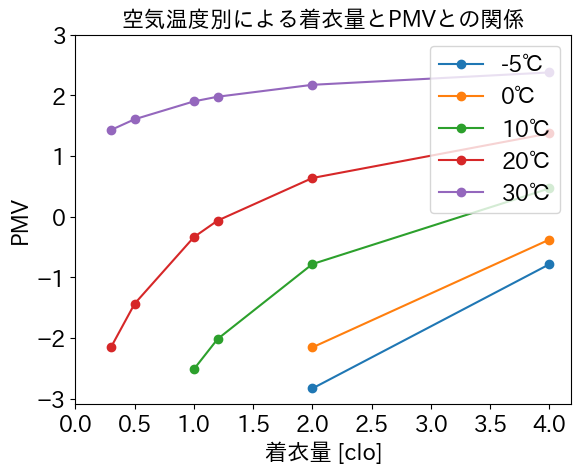

In [4]:
# 空気温度別による着衣量、PMVを示すグラフ

# パラメータ
M = 1.2 # 代謝量 [met]
var = 0.1 # 気流 [m/sec]
RH = 50 # 相対湿度 [%]

# 空気温度と平均放射温度は同じ温度とする (-5 ～ 30 ℃)。

clo_graph.clo_PMV(M, var, RH) # グラフ表示

代謝量 1.2 [met]、着衣量 1.0 [clo]、相対湿度 50 [%]とし、横軸に空気温度、縦軸に PMVを気流別(0.1 ～ 2.0 [m/sec])にプロットした。<br>
ただし、空気温度と平均放射温度は同じ温度とする 。<br>


-0.5 $\leq$ PMV $\leq$ 0.5 の快適域に該当するものは<br>
空気温度が20～25 ℃にかけてである。気流の速度に関係なく快適域に該当する。空気温度が30 ℃に達するとPMVは2.0 に収束し、風速が速くても暖かく感じる。

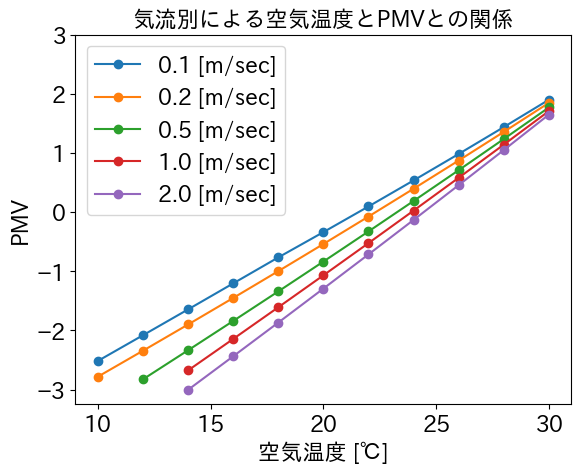

In [5]:
# 気流別による着衣量、PMVを示すグラフ
# パラメータ
M = 1.2 # 代謝量 [met]
Icl = 1 # 着衣量 [clo]
RH = 50 # 相対湿度 [%]

# 空気温度と平均放射温度は同じ温度とする (10 ～ 30 ℃)。

ta_graph.ta_var_PMV(M, Icl, RH)